In [1]:
import pandas as pd
%matplotlib ipympl
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.patches as mpatches
import numpy as np
import ipywidgets as widgets
import re
import ast
from scipy.stats import gaussian_kde

In [2]:
df = pd.read_csv('Repo_Messages_Huge_Set.csv')

In [3]:
print(df.shape)
print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))
print(df.head())

(4125158, 4)
Size of dataframe: 3221134332 Bytes
                                             message  \
0  Merge pull request #26 from plumgrid/fawadk-de...   
1  Merge pull request #48 from plumgrid/qasims-de...   
2  Update README.md\n\nAdding quick start instruc...   
3        Changed grid size for landscape orientation   
4                     Added Polish translation files   

                                              author  \
0  {'name': 'Fawad Khaliq', 'email': '4856592176e...   
1  {'name': 'Fawad Khaliq', 'email': '4856592176e...   
2  {'name': 'Muhammad Sagheer', 'email': '6e79461...   
3  {'name': 'Elman', 'email': '59c728d38dfde4d631...   
4  {'name': 'Elman', 'email': '59c728d38dfde4d631...   

                         repo  \
0  plumgrid/libnetwork-plugin   
1  plumgrid/libnetwork-plugin   
2  plumgrid/libnetwork-plugin   
3   elman22/pocket-amc-reader   
4   elman22/pocket-amc-reader   

                                            language  
0  [{'name': 'Go', 'byt

In [71]:
repoIndecies = {}
totalMessages = []
formatMessages = []
languageIndecies = {}
languageCounts = []
languageNames = []
biggestLanguages = []
authors = []
    
messages = 0
repos = 0
languages = 0
for index, row in df.iterrows():
    messages += 1
    if not row['repo'] in repoIndecies:
        repoIndecies[row['repo']] = repos
        totalMessages.append(0)
        formatMessages.append(0)

        biggestLanguages.append(0)
        maxBytes = 0
        maxLanguage = ''
        for language in ast.literal_eval(row['language']):
            if language['bytes'] > maxBytes:
                maxBytes = language['bytes']
                maxLanguage = language['name']
        if not maxLanguage in languageIndecies:
            languageIndecies[maxLanguage] = languages
            languageCounts.append(0)
            languageNames.append(maxLanguage)
            languages += 1
        biggestLanguages[repos] = languageIndecies[maxLanguage]
        languageCounts[languageIndecies[maxLanguage]] += 1

        authors.append({})
        repos += 1

    repoIndex = repoIndecies[row['repo']]
    totalMessages[repoIndex] += 1
    if type(row['message']) != float and re.search('[a-zA-Z0-9]+([(].*[)]){0,1}!{0,1}:[ ]*.*$', row['message']):
        formatMessages[repoIndex] += 1
    
    author = ast.literal_eval(row['author'])
    if not author['name'] in authors[repoIndex]:
        authors[repoIndex][author['name']] = 0
    authors[repoIndex][author['name']] += 1 #messages per author

messageRatios = []
authorCounts = []
for i in range(repos):
    messageRatios.append(formatMessages[i]/totalMessages[i])
    authorCounts.append(len(authors[i]))

In [83]:
DisplayedLanguages = 10
languageValues = [0]
languageLabels = ['Other']
languageSorter = np.array(languageCounts).argsort()
for i, j in enumerate(languageSorter[-DisplayedLanguages:]):
    if languageNames[j] == '':
        for k in range(i + 1):
            temp = languageSorter[-10 + i - k]
            languageSorter[-10 + i - k] = languageSorter[-10 + i - k - 1]
            languageSorter[-10 + i - k - 1] = temp

reverseSorter = []
for i in range(len(languageSorter)):
    reverseSorter.append(0)
for i, j in enumerate(languageSorter):
    reverseSorter[j] = i
languageRatios = []
for i in range(DisplayedLanguages + 1):
    languageRatios.append([])

for i in languageSorter[:-DisplayedLanguages]:
    languageValues[0] += languageCounts[i]
for i in languageSorter[-DisplayedLanguages:]:
    languageValues.append(languageCounts[i])
    languageLabels.append(languageNames[i])
for i in range(repos):
    if reverseSorter[biggestLanguages[i]] < (languages - DisplayedLanguages):
        languageRatios[0].append(messageRatios[i])
    else:
        languageRatios[reverseSorter[biggestLanguages[i]] - (languages - DisplayedLanguages) + 1].append(messageRatios[i])
print(languageLabels)
print(languageValues)

['Other', 'Shell', 'C', 'Go', 'HTML', 'C++', 'Ruby', 'PHP', 'Python', 'Java', 'JavaScript']
[2279, 276, 294, 317, 383, 447, 672, 815, 1114, 1312, 2091]


interactive(children=(IntSlider(value=196979, continuous_update=False, description='Y Upper Limit:', layout=La…

interactive(children=(Dropdown(description='Y axis:', layout=Layout(width='30%'), options=('Total Messages', '…

<function __main__.f(mode)>

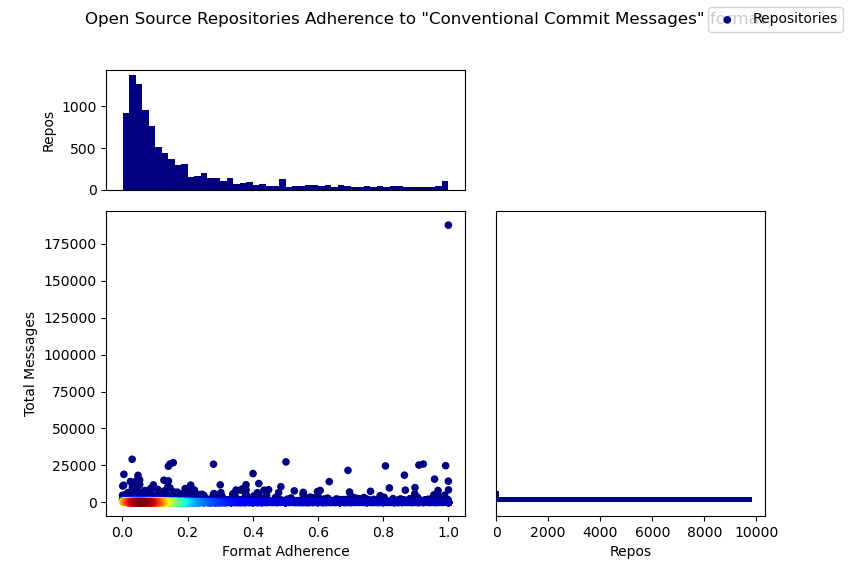

In [98]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8.5, 5.8), gridspec_kw={'width_ratios': [4, 3],
                                                                                 'height_ratios': [1.5,3.8],
                                                                                 'wspace': 0.1,
                                                                                 'hspace': 0.1})

ax2.axis('off')
ax1.set_xticks([])
ax4.set_yticks([])

yaxis = totalMessages
xy = np.vstack([messageRatios, yaxis])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = np.array(messageRatios)[idx], np.array(yaxis)[idx], z[idx]

ax3.scatter(x, y, c=z, s=20, cmap=colormaps['jet'], label='Repositories')

ylim = ax3.get_ylim()

ax3.set(ylabel='Total Messages', xlabel='Format Adherence')

ax1.hist(messageRatios, 50, color='navy')
ax1.set(ylabel='Repos')

ax4.hist(totalMessages, 50, orientation='horizontal', color='navy')
ax4.set(xlabel='Repos')

fig.suptitle('Open Source Repositories Adherence to "Conventional Commit Messages" format')
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = False
fig.canvas.resizable = False

def f2(scale):
    ax3.set_ylim([ylim[0] * scale / ylim[1], scale])

    ax4.clear()
    ax4.hist(list(filter(lambda x: x < scale, yaxis)), 50, orientation='horizontal', color='navy')
    ax4.set_ylim([ylim[0] * scale / ylim[1], scale])
    ax4.set_yticks([])
    ax4.set(xlabel='Repos')

scaleSlider = widgets.IntSlider( value=ylim[1],
                                    min=10,
                                    max=ylim[1],
                                    step=1,
                                    description='Y Upper Limit:',
                                    disabled=False,
                                    continuous_update=False,
                                    orientation='horizontal',
                                    readout=True,
                                    readout_format='d',
                                    layout=widgets.Layout(width='70%'))
widgets.interact(f2, scale=scaleSlider)

def f(mode):
    if mode == 'Total Messages':
        yaxis = totalMessages
        scaleSlider.disabled = False
    elif mode == 'Contributors':
        yaxis = authorCounts
        scaleSlider.disabled = False
    elif mode == 'Biggest Language':
        ax3.clear()
        for i, xaxis in enumerate(languageRatios):
            xy = np.vstack([xaxis])
            z = gaussian_kde(xy)(xy)

            idx = z.argsort()
            x, z = np.array(xaxis)[idx], z[idx]
            ax3.scatter(x, [i]*len(xaxis), c=z, s=20, cmap=colormaps['jet'], label='Repositories')
            ax3.set_yticks(range(DisplayedLanguages + 1), labels=languageLabels)
        ax3.set(ylabel=mode, xlabel='Format Adherence')

        ax4.clear()
        ax4.barh(np.arange(DisplayedLanguages + 1), languageValues, 0.3, color='navy')
        ax4.set_ylim(ax3.get_ylim())
        ax4.set_yticks([])
        ax4.set(xlabel='Repos')

        scaleSlider.disabled = True
        return

    xy = np.vstack([messageRatios, yaxis])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = np.array(messageRatios)[idx], np.array(yaxis)[idx], z[idx]
    ax3.clear()
    ax3.scatter(x, y, c=z, s=20, cmap=colormaps['jet'], label='Repositories')
    ax3.set(ylabel=mode, xlabel='Format Adherence')

    ylim = ax3.get_ylim()
    scaleSlider.value = ylim[1]
    scaleSlider.max = ylim[1]

    ax4.clear()
    ax4.hist(yaxis, 50, orientation='horizontal', color='navy')
    ax4.set_yticks([])
    ax4.set(xlabel='Repos')
    

widgets.interact(f, mode=widgets.Dropdown( options=['Total Messages', 'Contributors', 'Biggest Language'],
                                                value='Total Messages',
                                                description='Y axis:',
                                                style={'description_width': 'initial'},
                                                layout=widgets.Layout(width='30%') ))